### XGBoost

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
from skopt import BayesSearchCV
from matplotlib import pyplot
from xgboost import plot_importance
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

### Data manipulation

In [2]:
#####  Import Data  #####
train = pd.read_csv("../data/train_data_clean_4_grouped.csv")
test = pd.read_csv("../data/test_data_clean_4_grouped.csv")

#####  Encode gender and living status and state  #####
train["living_status"] = pd.Categorical(train["living_status"])
train["gender"] = np.where(train["gender"].str.contains("M"), 1, 0)
train["living_status"] = np.where(train["living_status"].str.contains("Rent"), 1, 0)

test["living_status"] = pd.Categorical(test["living_status"])
test["gender"] = np.where(test["gender"].str.contains("M"), 1, 0)
test["living_status"] = np.where(test["living_status"].str.contains("Rent"), 1, 0)

# one-hot encoding for site of state
state_dummies = pd.get_dummies(test['state'], 
                                  prefix='state', drop_first=True)
test = pd.concat([test, state_dummies], axis=1)
test.drop(["state"], axis=1, inplace=True)

# one-hot encoding for site of state
state_dummies = pd.get_dummies(train['state'], 
                                  prefix='state', drop_first=True)
train = pd.concat([train, state_dummies], axis=1)
train.drop(["state"], axis=1, inplace=True)


##### Drop month, day and year data, drop vehicle color, zipcode, claim_date, claim_number and SP_Index  #####
train.drop(["claim_month_january", "claim_month_february", "claim_month_march", "claim_month_may", 
              "claim_month_june", "claim_month_july", "claim_month_august", "claim_month_september", 
              "claim_month_october", "claim_month_november", "claim_month_december", 
              "claim_day_monday", "claim_day_tuesday", "claim_day_wednesday", "claim_day_thursday", 
               "claim_day_saturday", "claim_day_sunday", "claim_year", "claim_day", 
              "zip_code", "claim_date", "claim_number", 'SP_Index', "vehicle_color_blue", 
               "vehicle_color_gray", "vehicle_color_other", "vehicle_color_red", 
              "vehicle_color_silver", "vehicle_color_white"], axis =1, inplace=True)

test.drop(["claim_month_january", "claim_month_february", "claim_month_march", "claim_month_may", 
              "claim_month_june", "claim_month_july", "claim_month_august", "claim_month_september", 
              "claim_month_october", "claim_month_november", "claim_month_december", 
              "claim_day_monday", "claim_day_tuesday", "claim_day_wednesday", "claim_day_thursday", 
               "claim_day_saturday", "claim_day_sunday", "claim_year", "claim_day", 
              "zip_code", "claim_date", "claim_number", 'SP_Index', "vehicle_color_blue", 
               "vehicle_color_gray", "vehicle_color_other", "vehicle_color_red", 
              "vehicle_color_silver", "vehicle_color_white"], axis =1, inplace=True)


#####  Add saftyrating/(number of past claim) feature  #####
train['per_saftyrating'] = train['safty_rating']/(train['past_num_of_claims']+1)
test['per_saftyrating'] = test['safty_rating']/(test['past_num_of_claims']+1)


##### Delete some fraud_mean variables  #####
## The best result is to keep fraud_vehicle_color and fraud_state
train.drop(["fraud_gender", "fraud_marital_status", "fraud_high_education_ind", "fraud_address_change_ind", 
              "fraud_living_status", "fraud_zip_code", "fraud_claim_date", "fraud_witness_present_ind", 
              "fraud_policy_report_filed_ind", "fraud_accident_site", "fraud_channel", "fraud_vehicle_category",
           "fraud_vehicle_color", "fraud_state","Unem_rate"],
              axis = 1, inplace = True)
test.drop(["fraud_gender", "fraud_marital_status", "fraud_high_education_ind", "fraud_address_change_ind", 
              "fraud_living_status", "fraud_zip_code", "fraud_claim_date", "fraud_witness_present_ind", 
              "fraud_policy_report_filed_ind", "fraud_accident_site", "fraud_channel", "fraud_vehicle_category",
          "fraud_vehicle_color", "fraud_state", "Unem_rate"],
              axis = 1, inplace = True)
train = train.filter(regex="^(?!state_).*$")
test = test.filter(regex="^(?!state_).*$")

In [4]:
list(train)

['age_of_driver',
 'gender',
 'marital_status',
 'safty_rating',
 'annual_income',
 'high_education_ind',
 'address_change_ind',
 'living_status',
 'past_num_of_claims',
 'witness_present_ind',
 'liab_prct',
 'policy_report_filed_ind',
 'claim_est_payout',
 'age_of_vehicle',
 'vehicle_price',
 'vehicle_weight',
 'fraud',
 'latitude',
 'longitude',
 'accident_site_local',
 'accident_site_parking_lot',
 'channel_online',
 'channel_phone',
 'vehicle_category_large',
 'vehicle_category_medium',
 'Interest_rate',
 'per_saftyrating']

### CV AUC score, prediction, and feature importance.

[0.72161719 0.71784291 0.72342382 0.71238696 0.74069882 0.73470387]
AUC: 0.7251 (+/- 0.0097)


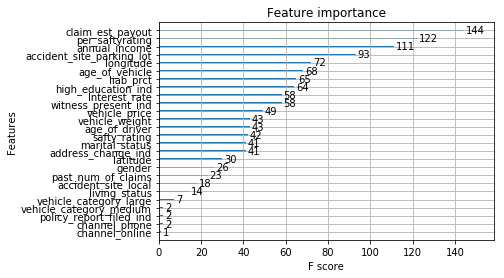

In [10]:
y = train["fraud"]
X = train.drop("fraud", 1)
clf = xgb.XGBClassifier(max_depth=3,
            learning_rate=0.06,
            n_estimators=180,
            silent=True,
            objective='binary:logistic',
            gamma=0.35,
            min_child_weight=5,
            max_delta_step=0,
            subsample=0.8,
            colsample_bytree=0.785,
            colsample_bylevel=1,
            reg_alpha=0.01,
            reg_lambda=1,
            scale_pos_weight=1,
            seed=1440,
            missing=None)

## CV AUC score
scores = model_selection.cross_val_score(clf, X.values, y.values, cv = 6, scoring = 'roc_auc')
print(scores)
print("AUC: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

## Final prediction on the test data
clf.fit(X, y)
y_pred = clf.predict_proba(test)[:,1]
test = pd.read_csv("../data/test_data_clean2.csv")
test_output = {'claim_number':test['claim_number'], 'fraud':y_pred}
test_output = pd.DataFrame(data = test_output)
test_output = test_output.set_index('claim_number')
test_output.to_csv("../data/predictions/prediction_xgboost.csv")

## Feature importance 
plot_importance(clf)
pyplot.show()